<a href="https://colab.research.google.com/github/ArtzTechnology/NWI-IR-2020/blob/main/dl_assignment_6_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning &mdash; Assignment 6

Sixth assignment for the 2021 Deep Learning course (NWI-IMC058) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_October 2021_

-----

**Names:** Dave Artz (s4475712) Daan Derks (s1011515)

**Group:** 32

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a variational auto encoder
2. Extend the model to a conditional VAE

## Required software

As before you will need these libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [ ]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.3 MB/s 


In [ ]:
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

## 6.1 MNIST dataset

In this assignment we will use the MNIST digit dataset. This dataset consists of 28×28 binary images and has 60000 training examples divded over 10 classes.

**(A) Run the code to load the MNIST dataset.**

In [ ]:
opts = {'batch_size':32, 'shuffle':True}
train_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    **opts)
test_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    **opts)
num_classes = 10

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 6.2 Variational Auto Encoder

We will implement a Variational Auto Encoder. This model consists of two networks, an encoder and a decoder.
The encoder produces a distribution in the latent space, represented as the parameters of a normal distribution. The decoder takes the latent space representation and produces an output in the data space.

**(A) Complete the implementation below**

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_size=2):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        self.encoder_part1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU()
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)
        
        # Components of the decoder
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # TODO: Choose an appropriate activation function for the final layer.
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder_part1(x)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        std_z = torch.exp(0.5*logvar_z)
        eps = torch.randn_like(std_z)
        # TODO: turn the sample ε from N(0,1) into a sample from N(μ,σ)
        return (eps * std_z) + mean_z

    def decode(self, z):
        h = self.decoder_part1_z(z)
        h = torch.reshape(h, (-1,64,7,7)) # Unflatten
        return self.decoder_part2(h)

    def forward(self, x):
        mean_z, logvar_z = self.encode(x)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z), mean_z, logvar_z

The decoder produces two outputs that together give the parameters of a normal distribution: mean and logvar, so $\mu$ and $\log(\sigma^2)$. The latter might seem strange, but there is a good reason for it. 

**(B) What can go wrong if the decoder network directly outputs σ?**

The larger the std, the harder it is to train the network. For stability and ease of training we use the log as a regulizer and the square to give the log the positive inputs it requires. We could also use the absolute value for this, but squaring emphasizes larger differences.

## 6.3 Loss function

The loss for a variational autoencoder consists of two parts:
1. The reconstruction loss, which is the log likelihood of the data,
$L_\text{R} = \log P(x\mid z)$.
2. The Kulback-Leibler divergence from the encoder output to the target distribution,
$L_\text{KL}= KL(Q(z)\| P(z))$.

In our case the data is binary, so we use binary cross entropy for the reconstruction loss.

The derivation of the KL loss term can be found in appendix B of the VAE paper; [Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014](https://arxiv.org/pdf/1312.6114.pdf), be careful about the minus sign.

**(A) Implement the KL loss term below**

In [ ]:
def reconstruction_loss(recon_x, x):
    return F.binary_cross_entropy(recon_x, x, reduction='sum')

def kl_loss(mean_z, logvar_z):
    # TODO: your code here
    std_z = torch.exp(0.5*logvar_z)
    encoder_output = torch.normal(mean_z, std_z)
    target_distribution = torch.normal(torch.zeros_like(mean_z), torch.ones_like(logvar_z))
    return F.kl_div(encoder_output, target_distribution)

def loss_function(recon_x, x, mean_z, logvar_z):
    l_r = reconstruction_loss(recon_x, x)
    l_kl = kl_loss(mean_z, logvar_z)
    return l_r + l_kl, l_r, l_kl

## 6.4 Training our VAE

**(A) Complete the training loop below**

In [ ]:
def train(model, num_epochs = 10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'test loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for i, (X, y) in enumerate(train_iter):
            X = X.to(device)
            optimizer.zero_grad()
            # TODO: compute the outputs and loss
            recon_x, mean_z, logvar_z = model.forward(X) 
            loss, loss_r, loss_kl = loss_function(recon_x, X, mean_z, logvar_z)

            # Optimize
            loss.backward()
            optimizer.step()
            
            # Track our progress
            metric.add(loss_r, loss_kl, X.shape[0])
            train_loss_r  = metric[0] / metric[2]
            train_loss_kl = metric[1] / metric[2]
            train_loss = train_loss_r + train_loss_kl
            if i > 0 and i % 50 == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, None))
        test_loss_r, test_loss_kl = test(model)
        test_loss = test_loss_r + test_loss_kl
        animator.add(epoch+1, (None, test_loss))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')
    print(f'training reconstruction loss {train_loss_r:.3f}, test reconstruction loss {test_loss_r:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, test KL loss {test_loss_kl:.3f}')


def test(model):
    model.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for i, (X, y) in enumerate(test_iter):
            X = X.to(device)
            # TODO: compute the outputs and loss
            recon_x, mean_z, logvar_z = model.forward(X) 
            loss, loss_r, loss_kl = loss_function(recon_x, X, mean_z, logvar_z)
            metric.add(loss_r, loss_kl, X.shape[0])
    test_loss_r  = metric[0] / metric[2]
    test_loss_kl = metric[1] / metric[2]
    return test_loss_r, test_loss_kl

**(B) Train the model**

training loss 152.302, test loss 151.878
training reconstruction loss 152.298, test reconstruction loss 151.875
training KL loss 0.004, test KL loss 0.003


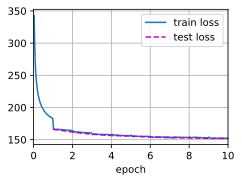

In [ ]:
device = d2l.try_gpu()
model = VAE().to(device)
train(model)

**(C) If you increase the numer of latent dimensions, how does that affect the reconstruction loss and the KL loss terms?**

training loss 150.765, test loss 150.004
training reconstruction loss 150.781, test reconstruction loss 150.020
training KL loss -0.016, test KL loss -0.016


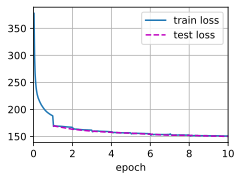

In [ ]:
model = VAE(latent_size=4).to(device)
train(model)

training loss 108.689, test loss 108.572
training reconstruction loss 108.689, test reconstruction loss 108.572
training KL loss -0.000, test KL loss 0.000


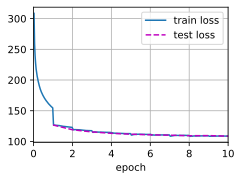

In [ ]:
model = VAE(latent_size=8).to(device)
train(model)

training loss 93.515, test loss 93.513
training reconstruction loss 93.520, test reconstruction loss 93.517
training KL loss -0.005, test KL loss -0.005


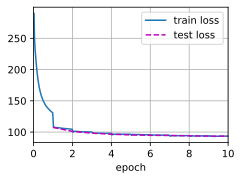

In [ ]:
model = VAE(latent_size=16).to(device)
train(model)

The KL loss becomes lower for latent size 4, higher for latent size 8 and lower for latent size 16. The reconstruction loss becomes lower for latent size 4 and 8 and rises for 16. The latent size could therefore be used as a fine tuning parameter as the KL loss is negligible for the training and test loss.

## 6.5 Visualizing the latent space

training loss 146.044, test loss 146.098
training reconstruction loss 146.052, test reconstruction loss 146.107
training KL loss -0.008, test KL loss -0.008


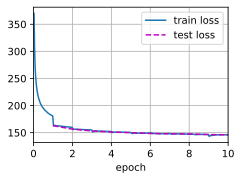

In [ ]:
model = VAE().to(device)
train(model)

We can use the function below to visualize the 2D latent space, by running the decoder on $z$ values sampled at regular intervals.

**(A) Complete the code below and run it to plot the latent space.**

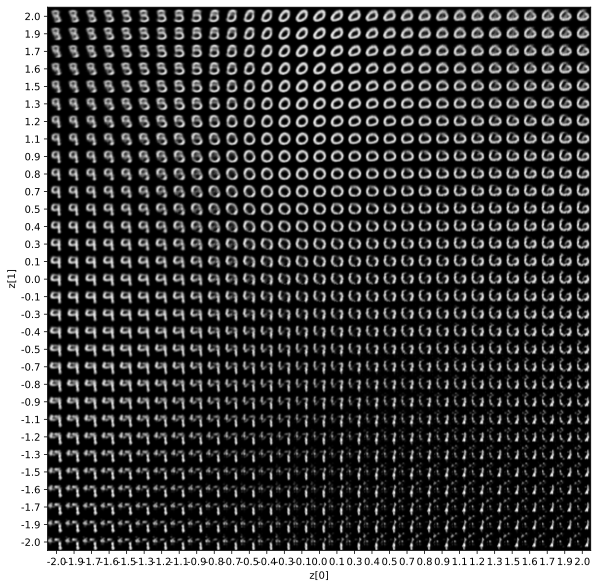

In [ ]:
def plot_latent(model):
    # display a n*n 2D manifold of digits
    n = 31
    digit_size = 28
    scale = 2.0
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # TODO: run the decoder on z = [xi,yi].
            z = torch.FloatTensor([xi,yi]).to(device)
            x_decoded = model.decode(z)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded.detach().cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(model)

**(B) Would it be possible to classify digits based on this latent representation?**

It would probably only be possible to classify the digits that are recognizable in the latent space. We expect that the two dimensional latent space is too small as there are only a few digits present that are recognizable. Hence we think that the latent space should have more dimensions to be able to classify all the digits correctly.

**(C) If you retrain the model, would you expect the latent space to look the same. If not, what differences can you expect?**

We do not expect the latent space to look exactly the same due to randomness, but we do expect to find a similar representation in which the same features are captured. The digits might be in different places with different transitions into one another. 

Another way of visualizing the latent space is by making a scatter plot of the training data in the latent space.

**(D) Complete and run the code below to make a scatterplot of the training data**

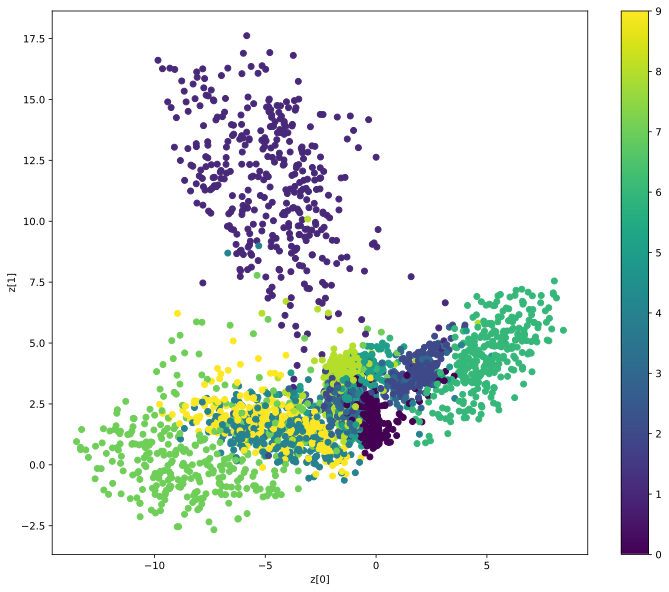

In [ ]:
def scatterplot_latent(model):
    # display a 2D plot of the digit classes in the latent space
    zs, ys = [], []
    for i, (X, y) in enumerate(train_iter):
        if i > 100: # Limit to a few batches to save memory
            break
        # TODO: compute mean z
        X = X.to(device)
        _, z_mean, _ = model.forward(X)
        zs.append(z_mean.detach().cpu())
        ys.append(y)
    zs = torch.cat(zs).numpy()
    ys = torch.cat(ys).numpy()
    
    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

scatterplot_latent(model)

**(E) Compare this figure to the previous one, what do you notice?**

We notice that many digits are scattered in a heap. This explains why we were only able to recognize a few digits in the previous figure. We expect that a scatter plot in which all digits are segmented by a more clear decision boundary will result into a latent space representation in which all the digits would be recognizable at some point.

**(F) Look at the distribution of the data in the latent space. What distribution do you expect it to have based on the theory? Does the plot match this?**

We make use of the KL loss, which compares the actual distribution with the normal distribution and the loss is minimized when the distributions match. So we expect based on the theory that the distribution of each digits tends to look like a normal distribution of mean 0 and a standard deviation of 1. It does not seem to match in this scatterplot. Some digits look like they are kind of matching the normal distribution (number 6) with a dense center and a more sparse outer rim. But others do not match at all, they can a dense cluster (like 8) or very sparse (like 7).

## 6.6 Conditional Variational Autoencoder

An extension of variational autoencoders uses labels to *condition* the encoder and decoder models.
In this conditional VAE, the decoder becomes $P(x|z,y)$ and the encoder $Q(z|x,y)$.
In practice this means that the label $y$ is given as an extra input to the both the encoder and the decoder.

For details see the paper [Semi-Supervised Learning with Deep Generative Models; Kingma, Rezende, Mohamed, Welling; 2014](https://arxiv.org/pdf/1406.5298.pdf).

To use the labels in the decoder, we can concatenate the label with the latent vector. Or equivalently, we can use separate weights for $z$ and $y$ in the first layer, so that layer computes $W_z * z + W_y * y + b$.

Similarly for the encoder, except there we will still use a convolutional layer for $x$, combined with a fully connected layer for $y$.

**(A) Complete the implementation of the conditional VAE below**

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_size=2, num_classes=10):
        super(ConditionalVAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        # TODO: split the first layer from the previous encoder network into a separate variable,
        #       and add a layer to use with the y input
        self.encoder_part1_x = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2)
        self.encoder_part1_y = nn.Linear(num_classes, 32*14*14)
        self.encoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU()
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)

        # Components of the decoder network
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        # TODO: add layer to use with the y input
        self.decoder_part1_y = nn.Linear(num_classes, 7*7*64)

        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # TODO: see VAE
            nn.Sigmoid()
        )

    def encode(self, x, y):
        h = self.encoder_part1_x(x) + self.encoder_part1_y(y).reshape(-1,32,14,14)
        h = self.encoder_part2(h)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        std_z = torch.exp(0.5*logvar_z)
        eps = torch.randn_like(std_z)
        # TODO: see VAE
        return eps * std_z + mean_z

    def decode(self, z, y):
        # TODO: use a first layer that combines z and y
        h = self.decoder_part1_z(z) + self.decoder_part1_y(y)
        h = torch.reshape(h, (-1,64,7,7))
        return self.decoder_part2(h)

    def forward(self, x, y):
        mean_z, logvar_z = self.encode(x, y)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z, y), mean_z, logvar_z

**(B) Copy the training code from section 6.4, and modify it for a conditional VAE**

Hint: To train the conditional VAE we need to use one-hot encoding of the labels. You can use the following code for that:

    y = F.one_hot(y,10).float().to(device)

In [ ]:
# TODO: your code here
def train_cvae(model, num_epochs = 10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'test loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for i, (X, y) in enumerate(train_iter):
            y = F.one_hot(y,10).float().to(device)
            X = X.to(device)
            optimizer.zero_grad()
            # TODO: compute the outputs and loss
            recon_x, mean_z, logvar_z = model.forward(X, y) 
            loss, loss_r, loss_kl = loss_function(recon_x, X, mean_z, logvar_z)

            # Optimize
            loss.backward()
            optimizer.step()
            
            # Track our progress
            metric.add(loss_r, loss_kl, X.shape[0])
            train_loss_r  = metric[0] / metric[2]
            train_loss_kl = metric[1] / metric[2]
            train_loss = train_loss_r + train_loss_kl
            if i > 0 and i % 50 == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, None))
        test_loss_r, test_loss_kl = test(model)
        test_loss = test_loss_r + test_loss_kl
        animator.add(epoch+1, (None, test_loss))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')
    print(f'training reconstruction loss {train_loss_r:.3f}, test reconstruction loss {test_loss_r:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, test KL loss {test_loss_kl:.3f}')


def test(model):
    model.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for i, (X, y) in enumerate(test_iter):
            X = X.to(device)
            y = F.one_hot(y,10).float().to(device)
            # TODO: compute the outputs and loss
            recon_x, mean_z, logvar_z = model.forward(X, y) 
            loss, loss_r, loss_kl = loss_function(recon_x, X, mean_z, logvar_z)
            metric.add(loss_r, loss_kl, X.shape[0])
    test_loss_r  = metric[0] / metric[2]
    test_loss_kl = metric[1] / metric[2]
    return test_loss_r, test_loss_kl

**(C) Train a conditional VAE**

training loss 124.898, test loss 125.211
training reconstruction loss 124.904, test reconstruction loss 125.216
training KL loss -0.005, test KL loss -0.005


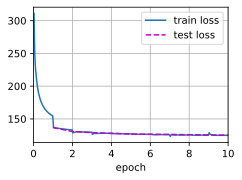

In [ ]:
cvae_model = ConditionalVAE().to(device)
train_cvae(cvae_model)

**(D) Adapt the `plot_latent` function from section 6.5 for conditional VAEs and use your function to visualize the latent space for a few classes.**

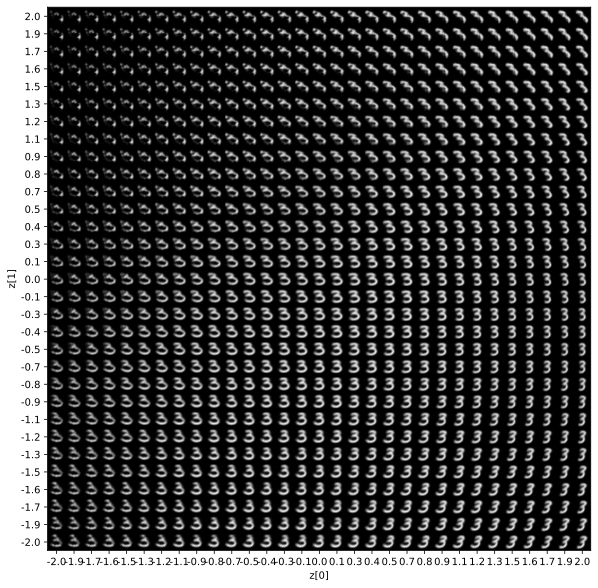

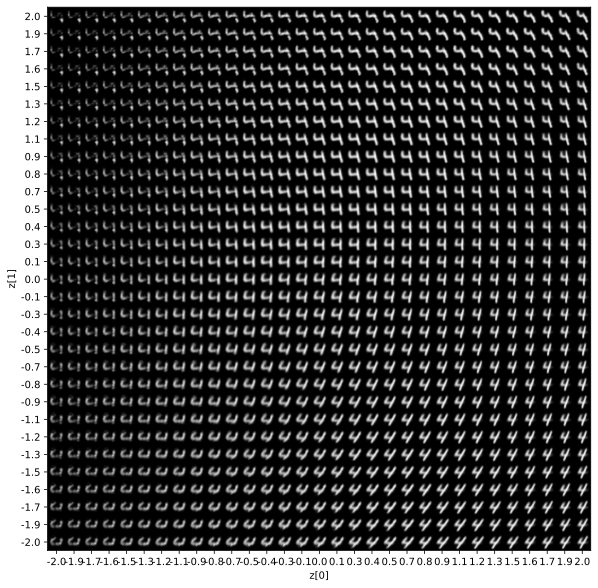

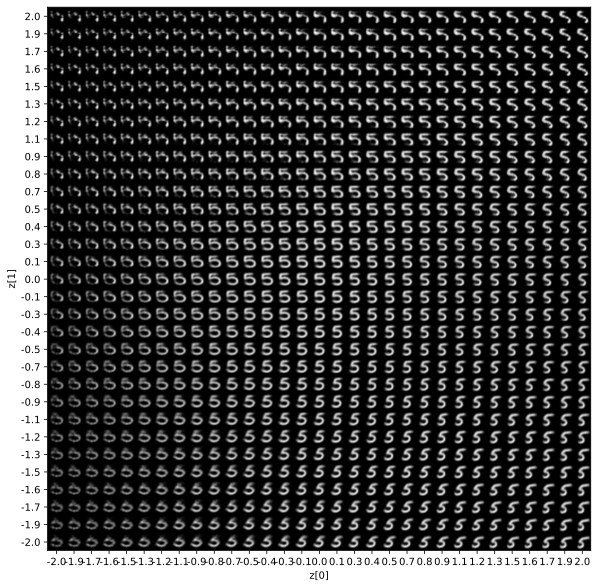

In [ ]:
def plot_latent(model, y):
    # display a n*n 2D manifold of digits
    n = 31
    digit_size = 28
    scale = 2.0
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # TODO: run the decoder on z = [xi,yi].
            z = torch.FloatTensor([xi,yi]).to(device)
            x_decoded = model.decode(z, y)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded.detach().cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

for i in range(3, 6):
  plot_latent(cvae_model, F.one_hot(torch.tensor([i]),10).float().to(device))

**(E) What do the latent dimensions represent? Is this the same for all labels?**

The latent space consist of filters for a certain digit and these filters have shapes that looks like that digit. One of the ground rules is: a filter that has a similar structure is able to classify/recognize that structure. This holds for all the labels.

**(F) Adapt `scatterplot_latent` to show the distribution in the latent space.**

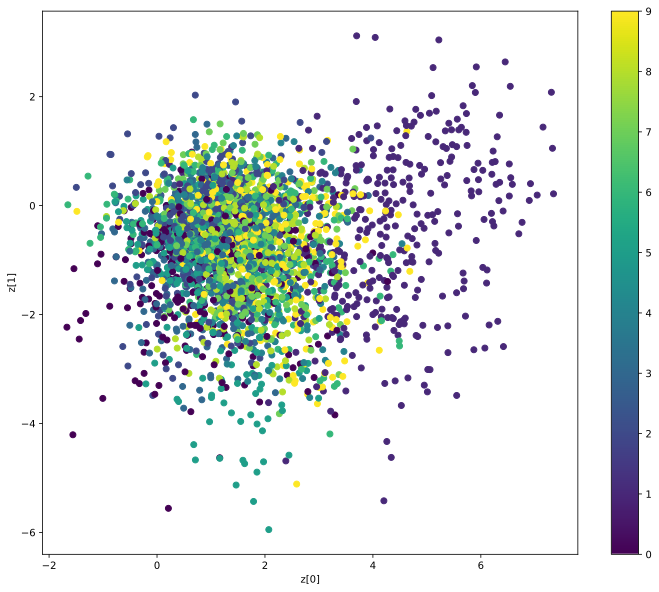

In [ ]:
def scatterplot_latent(model):
    # display a 2D plot of the digit classes in the latent space
    zs, ys = [], []
    for i, (X, y) in enumerate(train_iter):
        if i > 100: # Limit to a few batches to save memory
            break
        # TODO: compute mean z
        y_one_hot = F.one_hot(y,10).float().to(device)
        X = X.to(device)
        _, z_mean, _ = model.forward(X, y_one_hot)
        zs.append(z_mean.detach().cpu())
        ys.append(y)
    zs = torch.cat(zs).numpy()
    ys = torch.cat(ys).cpu().numpy()
    
    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

scatterplot_latent(cvae_model)

**(G) How is this distribution different from the distribution of the VAE? Does this match the theory?**

In 6.5F we claim that the plots of each digit needs to look like a normal distribution due to the KL loss. In this scatterplot it looks a lot better than in 6.5F. It looks that most of the digits have a centered mean and a standard deviation of 1. In contrast to this plot the previous plot of the VAE shows some digits that seperate themselves from others with a clear boundary.

**(H) Would it be possible to classify digits based on the latent representation of the conditional VAE?**

As all the digits are clustered in the same heap it would probabily not be possible to classify them based on the latent representation. In order to classify them we would need them to be clustered in different regions so that there is a clear decsion boundary visible.

**(I) How would you use a conditional VAE to change the label of an image, while keeping everything else as similar as possible?**

It would probably work if we condition on the old label in the encoder and condition on the new label in the decoder. The encoder will still update the latent space correctly as it has the correct label, but the decoder will take the features of the new label to recreate the image.

## 6.7 Discussion

**(A) Is the conditional VAE a strict improvement over the normal VAE in all cases?**

The CVAE has a lower loss than the normal VAE, this loss is reduced because the reconstruction loss is lower in the CVAE. So this model is better in reconstructing the numbers compared to the other. But if we compare the scatterplot from 6.5D (VAE) with the scatterplot from 6.6F (CVAE) we can conclude that we can draw better decision boundaries for VAE than CVAE for the most digits. We can only draw for digit 1 an decision boundary in 6.6F. From this we can conclude that the VAE is better in classifying the written digits compared to the CVAE. So the CVAE is not a strict improvement in all cases.

**(B) Compare the latent representation vector $z$ in the VAE with the input for the generator in a GAN. Are they the same thing?**

The input for the generator in a GAN can be random and not include anything or it can be a meaningful image. Although this image indirectly contains features, it is not the similar to the feature vector z.  The latent represenation might seem random, but it includes all the features it learned from the data. In theory you could throw in the vector used for the VAE into the generator of a GAN, but you could not use the input of the GAN as the latent representation vector.

## The end

Well done! Please double check the instructions at the top before you submit your results.